In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

from tabulate import tabulate

import json
from tqdm import tqdm

%run Code/plot_setup.py

%reload_ext autoreload
%autoreload 2

fig_path = "Figures_Plots/"


In [2]:
# initialise data
etf_data = pd.read_csv("Data/Data_ETFs_Info.csv")
etf_returns = pd.read_parquet("Data/Data_ETFs_Returns.gzip")

with open("Data/Data_ETFs_Names.json", "r") as openfile:
    # Reading from json file
    etf_dict = json.load(openfile)
    

etf_symbols = etf_dict.get("symbols")
etf_names = etf_dict.get("names")

# # date range
# start_date = "2015-01-01"
# end_date = "2022-12-01"

# start_date = str(etf_returns.index[0].date())
# end_date = str(etf_returns.index[-1].date())


In [3]:
# benchmarks
with open("Data/Benchmarks.json", "r") as openfile:
    # Reading from json file
    nord_benchmarks = json.load(openfile)
    
risk_level_weights = {}
for key,  item in nord_benchmarks.items():
    risk_level_weights[key] = [round(w, 4) for w in item.get("weights")]

In [4]:
from sklearn import preprocessing

# date where train ends
train_test_split = "2019-01-01"
# train_test_split = datetime.strptime(train_test_split, "%Y-%m-%d").date()

# train test split
train_returns = etf_returns.loc[etf_returns.index < train_test_split, :]
test_returns = etf_returns.loc[etf_returns.index >= train_test_split, :]


# Should we standardize test with train ?
train_st_returns = train_returns.apply(preprocessing.scale)
test_st_returns = test_returns.apply(preprocessing.scale)

print(f"Train returns shape: \t{train_returns.shape}")
print(f"Test returns shape: \t{test_returns.shape}")

Train returns shape: 	(207, 663)
Test returns shape: 	(205, 663)


In [13]:

nord_returns = test_returns[etf_symbols["nord"]].iloc[:-1,:]

nord_weights = pd.DataFrame({
    "NORD 5   (Risk profile 5)": risk_level_weights["nord_5"], 
    "NORD 13 (Risk profile 13)": risk_level_weights["nord_13"], 
    "NORD 20 (Risk profile 20)": risk_level_weights["nord_20"],
}, index = etf_symbols["nord"])

nord_port_returns = nord_returns @ nord_weights

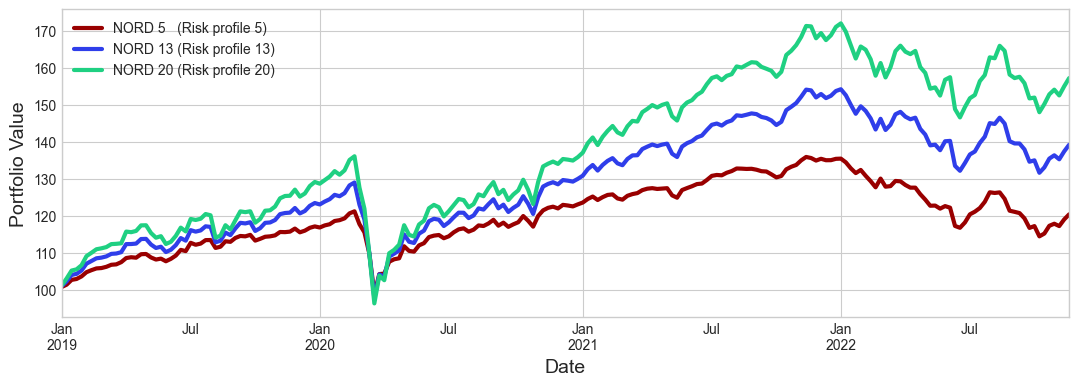

In [14]:

fig, ax = plt.subplots(figsize=(13,4))
budget = 100
(np.cumprod(1+nord_port_returns) * budget).plot(ax = ax);
# plt.title("Nord Investment Portfolios");
plt.xlabel("Date");
plt.ylabel("Portfolio Value");

plt.savefig(fig_path + 'Benchmarks_Risklevel_values.png', bbox_inches='tight')

In [15]:
from Code.functions import get_stats

tab = {}
for level in nord_port_returns.columns:
    tab[level] = get_stats(pd.DataFrame(nord_port_returns[level]))
    
tab = pd.DataFrame(tab)
print(tabulate(tab ,headers = "keys", floatfmt="0.2f", tablefmt = "latex"))

\begin{tabular}{lrrr}
\hline
                           &   NORD 5   (Risk profile 5) &   NORD 13 (Risk profile 13) &   NORD 20 (Risk profile 20) \\
\hline
 Weekly mean Returns (\%)   &                        0.10 &                        0.18 &                        0.25 \\
 Std of Weekly Returns (\%) &                        1.29 &                        1.71 &                        2.13 \\
 Annualized Returns (\%)    &                        4.86 &                        8.82 &                       12.25 \\
 Annualized Std (\%)        &                        9.31 &                       12.36 &                       15.33 \\
 Sharpe Ratio              &                        0.52 &                        0.71 &                        0.80 \\
 Starr Ratio               &                        1.49 &                        2.04 &                        2.30 \\
 CVaR (\%)                  &                       -3.26 &                       -4.33 &                       -5.32 \\